## **train a Spacy transformer based NER model**








this tutorial is about Training a custom NER model with spaCy Using it's pre-trained NER transformer model that extracts fashion related entities such us colors, print and patterns, product types...from clothing texts.

# **definitions**

**NER**

When reading a text, a human can identify named entities like dates, currencies, locations, person names, medical codes, brands, etc.
So, NER is basically making the computer automatically scan entire articles and pull out some fundamental entities in a text and classify them into predefined categories. Entities in our case are the features mentioned above This step can then be relevant for further information extraction from large text data 

**spacy**:
The spaCy library is a robust machine learning NLP library developed by Explosion AI, a Berlin based team of computer scientists and computational linguists. It supports a wide variety of European languages out-of-the-box with statistical models capable of parsing texts, identifying parts-of-speech, and extract entities. SpaCy is also capable of easily improving or training from scratch custom models on domain-specific texts.

**Transformers:**
Transformers are a family of neural network architectures that compute dense, context-sensitive representations for the tokens in documents. Downstream models in your pipeline can then use these representations as input features to improve their predictions.

Setup and installation

In [1]:
!pip install spacy[cuda100]
!pip install -U pip setuptools wheel
!pip install -U 'spacy[cuda100]'
!python -m spacy download en_core_web_trf
!pip install spacy-lookups-data#To install additional data tables for lemmatization and normalization 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58.9 MB 218 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 13.5 MB/s 
     |████████████████████████████████| 1.2 MB 59.0 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
numba 0.56.2 requires setuptools<60, but you have setuptools 65.4.1 which is inc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.3/460.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 70.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.2 MB/s eta 0:00:00


In [22]:
import spacy
spacy.load('en_core_web_trf')# to get all the Downloadable trained pipelines and weights for spaCy
gpu = spacy.prefer_gpu()
'''Allocate data and perform operations on GPU, if available. 
If data has already been allocated on CPU, it will not be moved.
 Ideally, this function should be called right after importing spaCy and before loading any pipelines. '''
print(gpu)
from thinc.api import set_gpu_allocator, require_gpu
# Use the GPU, with memory allocations directed via PyTorch.
# This prevents out-of-memory errors that would otherwise occur from competing
# memory pools.
set_gpu_allocator("pytorch")
require_gpu(0)

True


True

import the necessary libraries

In [4]:
import random
import time
import numpy as np
import sys
from spacy import displacy
from itertools import chain
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import json
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
from spacy.tokens import DocBin
import spacy  
from spacy.lookups import Lookups
lookups = Lookups()

training set(training and validation)

SpaCy requires that your training data be in a very specific form:

TRAIN_DATA = [ (TEXT AS A STRING, {“entities”: [(START, END, LABEL)]}) ]

For this task I come up with different approaches to collect the maximum amount of training data:

1.      Use NER Text Annotator : 
this free online annotation tools prouved to be very useful and easy to use 
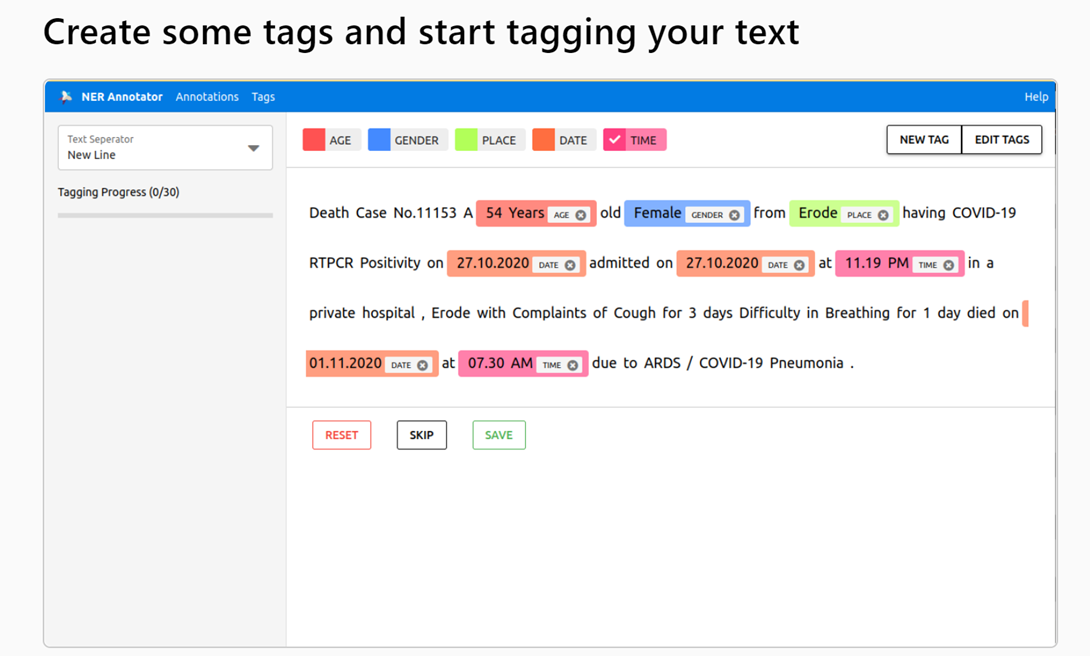

https://tecoholic.github.io/ner-annotator/

As shown in the figure:
 first, pass the text in the annotater along with the labels we aim to predict,
 second, select the word that corresponds to the label/TAG

 

2.  Along with the annotator we will generate training data using SEMI AUTOMATIC APPROACH:
Advanced Regular expressions, designing patterns using fashion dictionary/entity ruler,Rule-based Matching (check spacy rule-based matching and pipelines to understand how training data can be created with out the need of annotations)





    




In [5]:
f = open('final_train_data.json', encoding="utf8")
TRAIN = json.load(f)
TRAIN_annotation=TRAIN['annotations']
TRAIN_DATA, VALID_DATA = train_test_split(TRAIN_annotation, test_size=0.35, random_state=42 , shuffle=True)

In [6]:
print(len(VALID_DATA),len(TRAIN_DATA))

2741 5089


In [7]:
print(len(VALID_DATA),len(TRAIN_DATA))

2741 5089


In [8]:
del TRAIN_DATA[345:346]

Convert the Training Data to spaCy Binary Files¶

In [9]:
db = DocBin() # create a DocBin object
nlp = spacy.load("en_core_web_trf")

for text, annot in tqdm(TRAIN_DATA): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("./train.spacy") # save the docbin object

db = DocBin()
for text, annot in tqdm(VALID_DATA): # data in previous format
    doc = nlp.make_doc(text) # create doc object from text
    ents = []
    for start, end, label in annot["entities"]: # add character indexes
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    doc.ents = ents # label the text with the ents
    db.add(doc)

db.to_disk("./valid.spacy") # save the docbin object

 20%|█▉        | 1007/5088 [00:00<00:01, 2135.34it/s]

Skipping entity


 87%|████████▋ | 2383/2741 [00:00<00:00, 3360.55it/s]

Skipping entity


100%|██████████| 2741/2741 [00:00<00:00, 3283.88it/s]


Create the spaCy 3 config.cfg File

spacy offers a base configuration file that includes all settings and hyperparameters make sure to overwrite settings to fit ur own training.
     in my case i set the initial learning rate to 2.5e-5 along with the spacy-lookups-data

In [10]:
!python -m spacy init fill-config base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


Train the spaCy transformer model

In [11]:
import time
start_time = time.time()
!python -m spacy train config.cfg --verbose --output ./ner_demo/training/ --paths.train train.spacy --paths.dev valid.spacy --gpu-id 0 #--training.optimizer.learn_rate.initial_rate 0.1
print("--- %s secondes ---" % (time.time() - start_time))

[2022-10-05 17:49:15,116] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
DEBUG:spacy:Config overrides from CLI: ['paths.train', 'paths.dev']
✔ Created output directory: ner_demo/training
ℹ Saving to output directory: ner_demo/training
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-10-05 17:49:17,808] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-10-05 17:49:17,817] [DEBUG] Loading corpus from path: valid.spacy
DEBUG:spacy:Loading corpus from path: valid.spacy
[2022-10-05 17:49:17,818] [DEBUG] Loading corpus from path: train.spacy
DEBUG:spacy:Loading corpus from path: train.spacy
[2022-10-05 17:49:17,818] [INFO] Pipeline: ['transformer', 'ner']
INFO:spacy:Pipeline: ['transformer', 'ner']
[2022-10-05 17:49:17,822] [DEBUG] Loading lookups from spacy-lookups-data: ['lexeme_norm']
DEBUG:spacy:Loading lookups from spacy-lookups-data: ['lexeme_norm']
[2022-10-05 17:49:17,831] [INFO] Add

In [17]:
nlp_ner=spacy.load('/content/ner_demo/training/model-best')

In [20]:
doc=nlp_ner('i bought a red shoes made of wool with logo print on the back')
for ent in doc.ents:
  print(ent.text,ent.label_)

red COLOR
shoes PRODUCT
wool FABRIC
logo print on the back PRINT AND PATTERN


In [19]:
import pandas as pd    
s=pd.read_excel('s.xlsx')
from spacy import displacy
for m in s['product_description']:
    if type(m)!=float:
        doc3=nlp_ner(m)
        displacy.render(doc3, style="ent", jupyter=True,options={'distance':120})

/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:205: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)
